# 패키지 import & 하이퍼파라미터 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import Tensor

from typing import Any, Callable, List, Optional, Tuple
from tqdm import tqdm
import numpy as np
import random
# 하이퍼파라미터 설정
batch_size = 128
epochs = 100
learning_rate = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 및 로드

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # GoogLeNet의 입력 크기(224x224)로 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]), 
])

# 전체 데이터셋 로드(CIFAR10)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# 데이터셋 크기 확인
print(f"Train dataset size: {len(trainset)}")
print(f"Test dataset size: {len(testset)}")

# 첫 번째 배치 확인 (이미지와 라벨)
images, labels = next(iter(trainloader))
print(f"Batch image shape: {images.shape}")  # (batch_size, channels, height, width)
print(f"Batch labels: {labels[:5]}")  # 첫 5개 라벨 확인

100%|██████████| 170M/170M [00:03<00:00, 46.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train dataset size: 50000
Test dataset size: 10000
Batch image shape: torch.Size([128, 3, 224, 224])
Batch labels: tensor([3, 0, 9, 2, 0])


# GoogLeNet 모델 정의
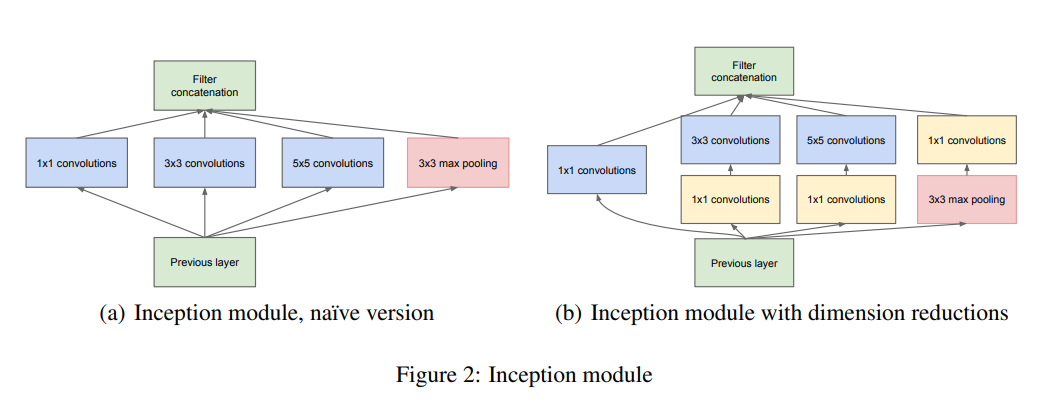

## BasicConv2d: Conv2d + BatchNorm + ReLU

In [3]:
# reference : https://pytorch.org/vision/main/_modules/torchvision/models/googlenet.html#googlenet
class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

## Inception v1
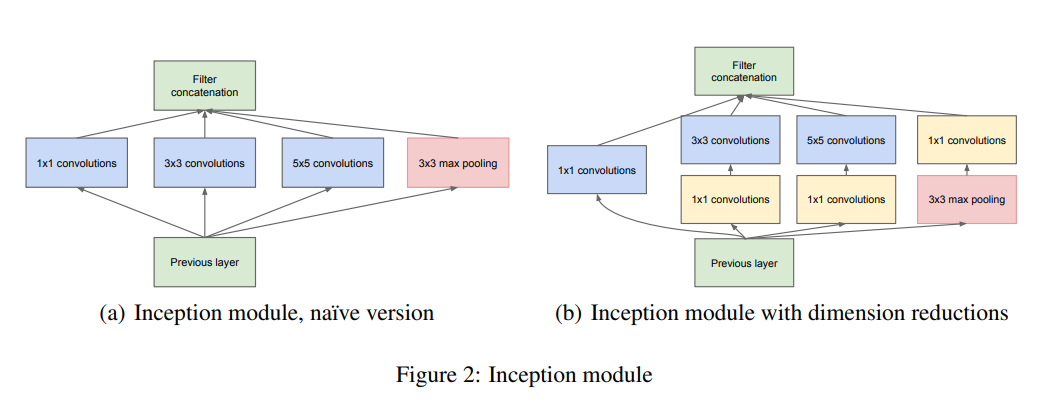

In [4]:
# Inception v1 module
class InceptionV1(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()
        self.branch1x1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1x1(x),
            self.branch3x3(x),
            self.branch5x5(x),
            self.branch_pool(x)
        ], 1)

## Auxiliary Classifier

In [5]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),  # Approx equivalent to kernel=5, stride=3
            nn.Conv2d(in_channels, 128, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## GoogLeNet

In [6]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True):
        super().__init__()
        self.aux_logits = aux_logits
        
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = InceptionV1(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionV1(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = InceptionV1(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionV1(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionV1(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionV1(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionV1(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        # Auxiliary classifiers
        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)  # after 4a
            self.aux2 = InceptionAux(528, num_classes)  # after 4d
        
        self.inception5a = InceptionV1(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionV1(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        aux1 = self.aux1(x) if self.aux_logits and self.training else None
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        aux2 = self.aux2(x) if self.aux_logits and self.training else None
        
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.aux_logits and self.training: # 학습 중 일때만 Auxiliary Classifier 적용, self.training은 nn.module가 관리하는 인스턴스 변수 -> eval mode에서 False로 처리됨
            return x, aux1, aux2
        else:
            return x

# GoogLeNet 구조 확인

In [7]:
import torchsummary
model = GoogLeNet(num_classes = 10).to(device) # 데이터 셋의 클래스 수 : 10개

torchsummary.summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

# 손실 함수, 옵티마이저, lr scheduler 설정

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(weight_decay=WEIGHT_DECAY, params=model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, verbose=True, patience=10)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# train

In [9]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Auxiliary classifier 지원
        if isinstance(outputs, tuple):
            main_output, aux1_output, aux2_output = outputs
            loss1 = criterion(main_output, labels)
            loss2 = criterion(aux1_output, labels)
            loss3 = criterion(aux2_output, labels)
            loss = loss1 + 0.3 * loss2 + 0.3 * loss3
            outputs = main_output  # 예측은 main output 기준
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# test

In [10]:
# 테스트 루프
def test(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Only use main output for evaluation

            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Evaluation

In [11]:
min_loss = np.inf
MODEL_NAME = "GoogLeNet_best"
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Early stopping 설정
patience = 5  # val_loss 개선되지 않는 최대 epoch 수
early_stop_counter = 0  # 개선되지 않은 epoch 수

# Epoch 별 train & test
for epoch in tqdm(range(epochs)):
    # Model Training
    # train result
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)

    # validation result
    val_loss, val_acc = test(model, testloader, criterion, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{MODEL_NAME}.pth')
        early_stop_counter = 0 # 개선되었으므로 early stopping counter 리셋
    else:
        early_stop_counter += 1 # 개선되지 않았으면 카운터 증가

    # learning rate update
    lr_scheduler.step(metrics=val_loss)
    
    # Epoch 별 결과
    print(f'epoch {epoch+1:02d}, train_loss: {train_loss:.5f}, train_acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
    # 결과 저장
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    
    # Early stopping
    if early_stop_counter >= patience:
        print(f'Early stopping at epoch {epoch}...')
        break

  1%|          | 1/100 [02:18<3:47:47, 138.05s/it]

[INFO] val_loss has been improved from inf to 1.16368. Saving Model!
epoch 01, train_loss: 2.23151, train_acc: 47.94600, val_loss: 1.16368, val_accuracy: 57.45000


  2%|▏         | 2/100 [04:38<3:47:23, 139.22s/it]

[INFO] val_loss has been improved from 1.16368 to 0.84556. Saving Model!
epoch 02, train_loss: 1.49202, train_acc: 67.39800, val_loss: 0.84556, val_accuracy: 69.82000


  3%|▎         | 3/100 [06:55<3:44:00, 138.56s/it]

[INFO] val_loss has been improved from 0.84556 to 0.78448. Saving Model!
epoch 03, train_loss: 1.16145, train_acc: 75.28000, val_loss: 0.78448, val_accuracy: 72.67000


  4%|▍         | 4/100 [09:15<3:42:34, 139.11s/it]

[INFO] val_loss has been improved from 0.78448 to 0.69615. Saving Model!
epoch 04, train_loss: 1.00669, train_acc: 79.07600, val_loss: 0.69615, val_accuracy: 76.14000


  5%|▌         | 5/100 [11:33<3:39:22, 138.56s/it]

epoch 05, train_loss: 0.88305, train_acc: 81.86000, val_loss: 0.91878, val_accuracy: 71.04000


  6%|▌         | 6/100 [13:51<3:36:49, 138.40s/it]

[INFO] val_loss has been improved from 0.69615 to 0.66571. Saving Model!
epoch 06, train_loss: 0.80066, train_acc: 83.68800, val_loss: 0.66571, val_accuracy: 77.35000


  7%|▋         | 7/100 [16:11<3:35:06, 138.78s/it]

[INFO] val_loss has been improved from 0.66571 to 0.59313. Saving Model!
epoch 07, train_loss: 0.71808, train_acc: 85.52400, val_loss: 0.59313, val_accuracy: 80.14000


  8%|▊         | 8/100 [18:28<3:32:21, 138.49s/it]

[INFO] val_loss has been improved from 0.59313 to 0.58017. Saving Model!
epoch 08, train_loss: 0.66352, train_acc: 86.79400, val_loss: 0.58017, val_accuracy: 80.48000


  9%|▉         | 9/100 [20:46<3:29:40, 138.25s/it]

[INFO] val_loss has been improved from 0.58017 to 0.53963. Saving Model!
epoch 09, train_loss: 0.61948, train_acc: 87.69400, val_loss: 0.53963, val_accuracy: 82.17000


 10%|█         | 10/100 [23:04<3:27:16, 138.18s/it]

epoch 10, train_loss: 0.56140, train_acc: 89.02600, val_loss: 0.65135, val_accuracy: 78.91000


 11%|█         | 11/100 [25:22<3:24:46, 138.05s/it]

[INFO] val_loss has been improved from 0.53963 to 0.49459. Saving Model!
epoch 11, train_loss: 0.52797, train_acc: 89.72200, val_loss: 0.49459, val_accuracy: 83.63000


 12%|█▏        | 12/100 [27:39<3:22:15, 137.90s/it]

epoch 12, train_loss: 0.49049, train_acc: 90.47600, val_loss: 0.51746, val_accuracy: 83.14000


 13%|█▎        | 13/100 [29:58<3:20:10, 138.05s/it]

epoch 13, train_loss: 0.45655, train_acc: 91.28200, val_loss: 0.52756, val_accuracy: 83.12000


 14%|█▍        | 14/100 [32:16<3:17:52, 138.05s/it]

[INFO] val_loss has been improved from 0.49459 to 0.47701. Saving Model!
epoch 14, train_loss: 0.42373, train_acc: 92.04400, val_loss: 0.47701, val_accuracy: 84.47000


 15%|█▌        | 15/100 [34:34<3:15:24, 137.93s/it]

epoch 15, train_loss: 0.40485, train_acc: 92.46400, val_loss: 0.50131, val_accuracy: 83.82000


 16%|█▌        | 16/100 [36:52<3:13:14, 138.03s/it]

epoch 16, train_loss: 0.38251, train_acc: 92.85200, val_loss: 0.54330, val_accuracy: 83.09000


 17%|█▋        | 17/100 [39:10<3:10:49, 137.95s/it]

epoch 17, train_loss: 0.34689, train_acc: 93.67200, val_loss: 0.47938, val_accuracy: 84.67000


 18%|█▊        | 18/100 [41:29<3:09:18, 138.52s/it]

epoch 18, train_loss: 0.33562, train_acc: 93.94200, val_loss: 0.52105, val_accuracy: 83.39000


 18%|█▊        | 18/100 [43:47<3:19:31, 145.99s/it]

epoch 19, train_loss: 0.32082, train_acc: 94.07200, val_loss: 0.50936, val_accuracy: 84.08000
Early stopping at epoch 18...


# train/valid acc,loss 시각화

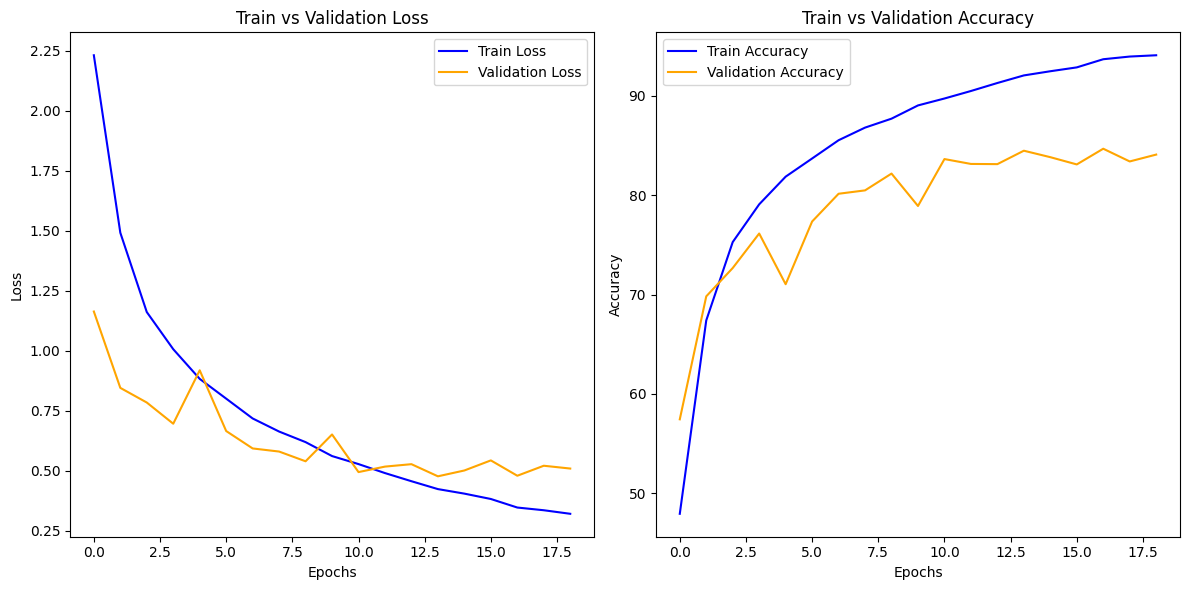

In [12]:
import matplotlib.pyplot as plt
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)

    # Loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
    plt.plot(range(epochs), val_losses, label='Validation Loss', color='orange')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)